# Deep Learning pipeline for Automatic Speech Recognizer
  
  The end-to-end Automatic Speech Recognizer makes use of RNN-CTC models for learning the speech from audio and producing transcripts. The spellings of the transcripts may not be correct using these models but the pronunciations are effectively converted to the transcripts.
  As a part of Deep Learning pipeline for Automatic Speech Recognizer project, we have implemented the following things:
  - Created a directory of audio files to effectively track location of audio files in the subfolders.
  - Converted raw audio from .flac to .wav
  - Used MFCC, Spectrogram features to get features from raw audio
  - Used MFCC features for training various Recurrent Neural Network models
  - Trained basic RNN models on LibriSpeech dataset, to explore the RNN architecture and the difference between basic Recurrent Neural Network architectures and their effectiveness for ASR. The effectiveness of the RNN models is measured in terms of the loss of the model. Performance metric used is CTC(Connectionist Temporal Classification) loss.
  - Used N-gram language model to correct the spellings obtained from model's predicted transcript text 
  

# Dataset used- LibriSpeech Dataset by Daniel Povey
  
  For training purposes, text data is aligned with the speech using language models to get small snippets of audio along with the text. The data can be downloaded with the link: [LibriSpeech](http://www.openslr.org/12/)


In [0]:
pwd

'/content/drive/My Drive/Colab Notebooks/projFin'

# Step 1: Installing libraries needed for the project

In [0]:
!pip install python_speech_features
!pip install soundfile

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp36-none-any.whl size=5887 sha256=07ddcea6ac8ce51fc229c79c4421cabcfca31703eea2aa25b732c030c4930096
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


In [0]:
# !sudo apt-get update -y
# !sudo apt-get install -y ffmpeg
# !wget http://launchpadlibrarian.net/348889634/libav-tools_3.4.1-1_all.deb
# !sudo dpkg -i libav-tools_3.4.1-1_all.deb
# !sh ./flac_to_wav.sh

# Step 2: Creating directory of audio files
  
  This creates a json file containing the details of the each of the audio file mentioning its subpath and the speech text. The resulting json file is used as a base for training the RNN models.   
    
    Example json record: 
      {"key": "LibriSpeech/dev-clean/422/122949/422-122949-0000.wav",   
      "duration": 20.22,   
      "text": "every elevation of the type man has hitherto been the work of an aristocratic society and so it will always be a society believing in a long scale of gradations of rank and differences of worth among human beings and requiring slavery in some form or other"}

In [0]:
# Creating a json file as a dictionary to locate all the audio files along with their addresses
!python create_desc_json.py LibriSpeech/dev-clean/ train_corpus.json
!python create_desc_json.py LibriSpeech/test-clean/ valid_corpus.json

# Step 3: Importing supporting libraries and methods for the program

In [0]:
ls

char_map.py              __pycache__/             train_corpus.json
create_desc_json.py      README.md                train_dev_corpus.json
data_generator.py        requirements.txt         train_utils.py
finalProj_updated.ipynb  results/                 utils.py
images/                  sample_models.py         valid_corpus.json
languageModel.py         test.py                  Video/
LibriSpeech/             train_clean_corpus.json  vui_notebook_BACKUP.ipynb


In [0]:
# Running the supporting python methods so that they can be invoked in this notebook later
!python char_map.py
!python data_generator.py
!python languageModel.py
!python sample_models.py
!python utils.py

Using TensorFlow backend.
2020-05-14 04:09:42.665335: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1


In [0]:
# Running the supporting python methods so that they can be invoked in this notebook later
!python train_utils.py

Using TensorFlow backend.
2020-05-14 04:13:07.502688: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-05-14 04:13:09.443204: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-05-14 04:13:09.509093: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2020-05-14 04:13:09.509199: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (a43852f3e4d2): /proc/driver/nvidia/version does not exist
2020-05-14 04:13:09.546418: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 2200000000 Hz
2020-05-14 04:13:09.546745: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x6ff2a80 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-05-14 04:13:0

In [0]:
import numpy as np
import os
import _pickle as pickle
import re
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from collections import Counter, defaultdict
from textblob import TextBlob

from IPython.display import Markdown, display
from IPython.display import Audio
from keras import backend as K
from keras.models import Model
from keras.layers import (BatchNormalization, Conv1D, Dense, Input, 
    TimeDistributed, Activation, Bidirectional, SimpleRNN, GRU, LSTM, Dropout, AtrousConvolution1D,Lambda)
from keras.optimizers import SGD, Adam, Adagrad
from keras.callbacks import ModelCheckpoint   

from data_generator import AudioGenerator, plot_mfcc_feature, plot_spectrogram_feature, vis_train_features, plot_raw_audio
from utils import int_sequence_to_text

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# Step 4: Data Visualization of the audio features

In [0]:
# extract label and audio features for a single training example
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()

There are 2136 total training examples.


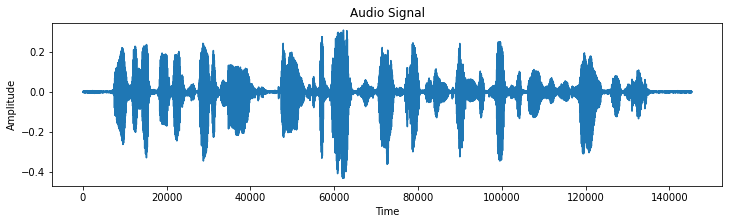

'Shape of Audio Signal : (145310,)'

"Transcript : he was in a fevered state of mind owing to the blight his wife's action threatened to cast upon his entire future"

In [0]:
%matplotlib inline
# plot audio signal
plot_raw_audio(vis_raw_audio)
# print length of audio signal
display('Shape of Audio Signal : ' + str(vis_raw_audio.shape))
display('Transcript : ' + str(vis_text))
# play the audio file
Audio(vis_audio_path)

# Step 4: Data Preprocessing- Converting raw audio features to spectogram features
  
  - What is Spectrogram?  
       "A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time."[1]  
  - The Spectrogram is derived as follows:  
      The audio signal is split into corresponding frequencies and plotted with respect to the time. At any given point, the intensity of color represents the amplitude of the signal on the spectrogram
      

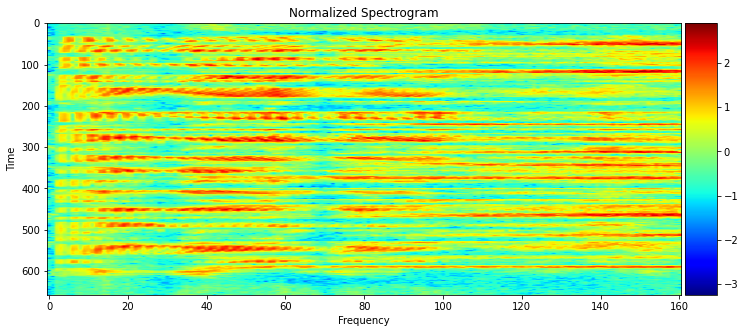

**Shape of Spectrogram** : (658, 161)

In [0]:
# plot normalized spectrogram
plot_spectrogram_feature(vis_spectrogram_feature)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape)))

# Step 5: Data Preprocessing- Converting raw audio features to MFCC features
  
- What is MFCC?  
  “the mel-frequency cepstrum (MFC) is a representation of the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency.”[2]
- MFCCs are commonly derived as follows:[2] [3, pp. 543–565] 
    •	Take the Fourier transform of (a windowed excerpt of) a signal.  
    •	Map the powers of the spectrum obtained above onto the mel scale, using overlapping triangular windows.  
    •	Take the logs of the powers at each of the mel frequencies.  
    •	Take the discrete cosine transform of the list of mel log powers, as if it were a signal.  
    •	The MFCCs are the amplitudes of the resulting spectrum  


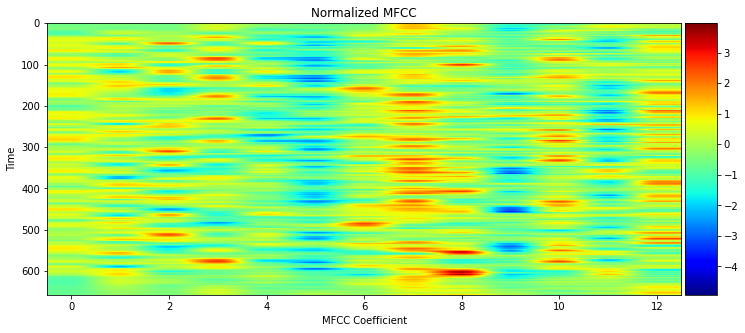

**Shape of MFCC** : (658, 13)

In [0]:
# plot normalized MFCC
plot_mfcc_feature(vis_mfcc_feature)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape)))

# Comparison between Spectrogram and MFCC. 
- The number of MFCC features generated per audio wave are very less compared to Spectrogram features.
- Use of MFCC fatures would result in less time and space complexity for the models to be trained. But MFCC features are less so they may not represent the audio completely. Use of MFCC features pose overfitting issue for smaller datasets.
- Since, there only 2136 training examples, we used Spectrogram features so that the neural network learns the features better. Use of Spectrogram features would help the model generalize better.

In [0]:
import tensorflow as tf
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


# Recurrent Neural Network specifications for all the models implemeted-

## Input to the RNN Model- 
- Time Series Spectrogram features of audio files 
- The speech text of the audio from the json file created earlier

## Output from the RNN Model-
- 29 graphemes
- 29 graphemes consists of 26 alphabets, one apostrophe, a space and an extra empty character used for padding to address unequal lengths of text.

In [0]:
"""
Defines two dictionaries for converting 
between text and integer sequences.
"""

char_map_str = """
' 0
<SPACE> 1
a 2
b 3
c 4
d 5
e 6
f 7
g 8
h 9
i 10
j 11
k 12
l 13
m 14
n 15
o 16
p 17
q 18
r 19
s 20
t 21
u 22
v 23
w 24
x 25
y 26
z 27
"""
# the "blank" character is mapped to 28

char_map = {}
index_map = {}
for line in char_map_str.strip().split('\n'):
    ch, index = line.split()
    char_map[ch] = int(index)
    index_map[int(index)+1] = ch
index_map[2] = ' '

## Model Techniques used:
- Recurrent: In this model, connections between nodes form a directed graph along a sequence. And this sequence allows it to exhibit dynamic temporal behavior for a time sequence. We used LSTM and GRU methods to implement Recurrent Neural Networks.
- Convolution: This layer's use helps the network to learn filters that activate when it detects some specific type of feature at some spatial position in the input.
- Time Distributed Dense: Dense layers are the traditional fully connected networks that map the convolutional layers' scores into the correct labels with some activation function (softmax used here). A time distributed dense layer is used to keep one-to-one relations on input and output
- BatchNormalization: Normalizes the batch of vectors such that mean is zero and standard deviation is 1.
- Droput: Dropout is used to avoid overfitting of the neural networks
- Activation function: We used Softmax to predict output of the models built. Softmax gives the class probabilities as the output.



# Step 6: Define a simple RNN model  
- The model uses Spectrogram features. Please refer the model summary for exact RNN layers

In [0]:

def simple_rnn_model(input_dim, output_dim=29):
    """ Build a recurrent network for speech 
    """
    # Main acoustic input
    input_data = Input(name='the_input', shape=(None, input_dim))
    # Add recurrent layer
    simp_rnn = LSTM(output_dim, return_sequences=True, 
                 implementation=2, name='rnn')(input_data)
    # Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(simp_rnn)
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: x
    print(model.summary())
    return model

In [0]:
model_0 = simple_rnn_model(input_dim=161)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (LSTM)                   (None, None, 29)          22156     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 22,156
Trainable params: 22,156
Non-trainable params: 0
_________________________________________________________________
None


# Step 7: Define a method to train RNN models using CTC loss function as a performance metric

In [0]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

def add_ctc_loss(input_to_softmax):
    """
    CTC loss is used as performace metric for the models implemented
    """
    the_labels = Input(name='the_labels', shape=(None,), dtype='float32')
    input_lengths = Input(name='input_length', shape=(1,), dtype='int64')
    label_lengths = Input(name='label_length', shape=(1,), dtype='int64')
    output_lengths = Lambda(input_to_softmax.output_length)(input_lengths)
    # CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
        [input_to_softmax.output, the_labels, output_lengths, label_lengths])
    model = Model(
        inputs=[input_to_softmax.input, the_labels, input_lengths, label_lengths], 
        outputs=loss_out)
    return model

def train_model(input_to_softmax, 
                pickle_path,
                save_model_path,
                train_json='train_corpus.json',
                valid_json='valid_corpus.json',
                minibatch_size=20,
                spectrogram=True,
                mfcc_dim=13,
                optimizer=SGD(lr=0.005, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5),
                #optimizer=Adagrad(lr=0.005),
                epochs=20,
                verbose=1,
                sort_by_duration=False,
                max_duration=10.0):
    """
    A common function used to train RNN models.
    Important method in this implementation- optimizer as it uses clipnorm to address RNN issues
    """
    # create a class instance for obtaining batches of data
    audio_gen = AudioGenerator(minibatch_size=minibatch_size, 
        spectrogram=spectrogram, mfcc_dim=mfcc_dim, max_duration=max_duration,
        sort_by_duration=sort_by_duration)
    # add the training data to the generator
    audio_gen.load_train_data(train_json)
    audio_gen.load_validation_data(valid_json)
    # calculate steps_per_epoch
    num_train_examples=len(audio_gen.train_audio_paths)
    steps_per_epoch = num_train_examples//minibatch_size
    # calculate validation_steps
    num_valid_samples = len(audio_gen.valid_audio_paths) 
    validation_steps = num_valid_samples//minibatch_size
    
    # add CTC loss to the NN specified in input_to_softmax
    model = add_ctc_loss(input_to_softmax)

    # CTC loss is implemented elsewhere, so use a dummy lambda function for the loss
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=optimizer)


    # add checkpointer
    checkpointer = ModelCheckpoint(filepath='results/'+save_model_path, verbose=0)

    # train the model
    hist = model.fit_generator(generator=audio_gen.next_train(), steps_per_epoch=steps_per_epoch,
        epochs=epochs, validation_data=audio_gen.next_valid(), validation_steps=validation_steps,
        callbacks=[checkpointer], verbose=verbose)

    # save model loss
    with open('results/'+pickle_path, 'wb') as f:
        pickle.dump(hist.history, f)

# Step 8: Train Simple RNN model

In [0]:
# make results/ directory, if necessary
if not os.path.exists('results'):
    os.makedirs('results')
train_model(input_to_softmax=model_0, 
            pickle_path='model_0.pickle', 
            save_model_path='model_0.h5',
            spectrogram=True,
            train_json='train_dev_corpus.json',
            epochs=20)

Epoch 1/20
106/106 [==============================] - 125s 1s/step - loss: 981.8602 - val_loss: 594.8978
Epoch 2/20
106/106 [==============================] - 124s 1s/step - loss: 752.8782 - val_loss: 790.5952
Epoch 3/20
106/106 [==============================] - 121s 1s/step - loss: 752.9938 - val_loss: 764.1744
Epoch 4/20
106/106 [==============================] - 121s 1s/step - loss: 752.0461 - val_loss: 741.9335
Epoch 5/20
106/106 [==============================] - 122s 1s/step - loss: 752.6505 - val_loss: 703.8338
Epoch 6/20
106/106 [==============================] - 122s 1s/step - loss: 752.3378 - val_loss: 840.4260
Epoch 7/20
106/106 [==============================] - 122s 1s/step - loss: 752.0928 - val_loss: 731.7635
Epoch 8/20
106/106 [==============================] - 121s 1s/step - loss: 754.1457 - val_loss: 791.4047
Epoch 9/20
106/106 [==============================] - 124s 1s/step - loss: 752.8815 - val_loss: 842.1004
Epoch 10/20
106/106 [==============================] - 

# Step 9: Building and training various simple RNN architectures
  
  Models trained are as follows:
  - A Simple RNN Model that uses LSTM layer without dropout, BatchNormalization
  - An RNN model with BatchNormalization, TimeDistributedDense layer
  - A CNN-RNN Architecture with one 1D convolutional layer whose output is given as input to the RNN layer
  - A Deep RNN Architecture that uses multiple recurrent layers (GRU). We implemented two recurrent layers, can increase by changing n_layers
  - A Bidirectional RNN architecture which uses two recurrent layers with same input and the output of these recurrent layers is given to TimeDistributedDense layer

In [0]:
def rnn_model(input_dim, units, activation, output_dim=29):
    """ 
    Build a recurrent network for speech 
    
    """
    # Main acoustic input
    input_data = Input(name='the_input', shape=(None, input_dim))
    # Add recurrent layer
    simp_rnn = GRU(units, activation=activation,
        return_sequences=True, implementation=2, name='rnn')(input_data)
    # batch normalization 
    bn_rnn = BatchNormalization(name="bn_rnn")(simp_rnn)
    # Add a TimeDistributed(Dense(output_dim)) layer
    time_dense = TimeDistributed(Dense(output_dim))(bn_rnn)
    # Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: x
    print(model.summary())
    return model

In [0]:
model_1 = rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                    units=200,
                    activation='relu')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         217200    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 223,829
Trainable params: 223,429
Non-trainable params: 400
_________________________________________________________________
None


In [0]:
def cnn_output_length(input_length, filter_size, border_mode, stride,
                       dilation=1):
    """ Compute the length of the output sequence after 1D convolution along
        time. Note that this function is in line with the function used in
        Convolution1D class from Keras.
    Params:
        input_length (int): Length of the input sequence.
        filter_size (int): Width of the convolution kernel.
        border_mode (str): Only support `same` or `valid`.
        stride (int): Stride size used in 1D convolution.
        dilation (int)
    """
    if input_length is None:
        return None
    assert border_mode in {'same', 'valid'}
    dilated_filter_size = filter_size + (filter_size - 1) * (dilation - 1)
    if border_mode == 'same':
        output_length = input_length
    elif border_mode == 'valid':
        output_length = input_length - dilated_filter_size + 1
    return (output_length + stride - 1) // stride

def cnn_rnn_model(input_dim, filters, kernel_size, conv_stride,
    conv_border_mode, units, output_dim=29):
    """ Build a recurrent + convolutional network for speech 
    """
    # Main acoustic input
    input_data = Input(name='the_input', shape=(None, input_dim))
    # Add convolutional layer
    conv_1d = Conv1D(filters, kernel_size, 
                     strides=conv_stride, 
                     padding=conv_border_mode,
                     activation='relu',
                     name='conv1d')(input_data)
    # Add batch normalization
    bn_cnn = BatchNormalization(name='bn_conv_1d')(conv_1d)
    # Add a recurrent layer
    simp_rnn = GRU(units, activation='relu',
        return_sequences=True, implementation=2, name='rnn')(bn_cnn)
    # Add batch normalization
    bn_rnn = BatchNormalization(name="bn_rnn")(simp_rnn)
    # Add a TimeDistributed(Dense(output_dim)) layer
    time_dense = TimeDistributed(Dense(output_dim))(bn_rnn)
    # Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)
    print(model.summary())
    return model

In [0]:
model_2 = cnn_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         240600    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0   

In [0]:
train_model(input_to_softmax=model_1, 
            pickle_path='model_1.pickle', 
            save_model_path='model_1.h5',
            spectrogram=True, # change to False if you would like to use MFCC features
            train_json='train_dev_corpus.json',
            epochs=20)

Epoch 1/20
106/106 [==============================] - 463s 4s/step - loss: 308.7207 - val_loss: 293.2402
Epoch 2/20
106/106 [==============================] - 471s 4s/step - loss: 230.3938 - val_loss: 218.5550
Epoch 3/20
106/106 [==============================] - 470s 4s/step - loss: 202.5687 - val_loss: 190.6399
Epoch 4/20
106/106 [==============================] - 467s 4s/step - loss: 191.0640 - val_loss: 166.6438
Epoch 5/20
106/106 [==============================] - 465s 4s/step - loss: 181.4603 - val_loss: 160.3820
Epoch 6/20
106/106 [==============================] - 470s 4s/step - loss: 173.8607 - val_loss: 128.3136
Epoch 7/20
106/106 [==============================] - 465s 4s/step - loss: 166.9577 - val_loss: 184.4938
Epoch 8/20
106/106 [==============================] - 463s 4s/step - loss: 160.8228 - val_loss: 174.3762
Epoch 9/20
106/106 [==============================] - 457s 4s/step - loss: 155.1455 - val_loss: 159.4931
Epoch 10/20
106/106 [==============================] - 

In [0]:
train_model(input_to_softmax=model_2, 
            pickle_path='model_2.pickle', 
            save_model_path='model_2.h5', 
            spectrogram=True, # change to False if you would like to use MFCC features
            train_json='train_dev_corpus.json',
            epochs=20)

Epoch 1/20
106/106 [==============================] - 322s 3s/step - loss: 254.2363 - val_loss: 187.4097
Epoch 2/20
106/106 [==============================] - 322s 3s/step - loss: 190.5055 - val_loss: 180.4740
Epoch 3/20
106/106 [==============================] - 343s 3s/step - loss: 168.4857 - val_loss: 166.6125
Epoch 4/20
106/106 [==============================] - 321s 3s/step - loss: 156.3507 - val_loss: 170.6489
Epoch 5/20
106/106 [==============================] - 340s 3s/step - loss: 147.6529 - val_loss: 158.6915
Epoch 6/20
106/106 [==============================] - 338s 3s/step - loss: 140.3493 - val_loss: 151.9201
Epoch 7/20
106/106 [==============================] - 335s 3s/step - loss: 135.0929 - val_loss: 139.7302
Epoch 8/20
106/106 [==============================] - 350s 3s/step - loss: 130.3591 - val_loss: 126.9721
Epoch 9/20
106/106 [==============================] - 347s 3s/step - loss: 126.5652 - val_loss: 140.0028
Epoch 10/20
106/106 [==============================] - 

In [0]:
def deep_rnn_model(input_dim, units, recur_layers, output_dim=29):
    """ Build a deep recurrent network for speech 
    """
    # Main acoustic input
    input_data = Input(name='the_input', shape=(None, input_dim))
    # Add recurrent layers, each with batch normalization
    simp_rnn = GRU(units, return_sequences=True, implementation=2, name='rnn')(input_data)
    # Add batch normalization
    bn_rnn = BatchNormalization(name="bn_rnn")(simp_rnn)
    for i in range(recur_layers-1):
        simp_rnn = GRU(units,name="rnn"+str(i),return_sequences=True, implementation=2)(bn_rnn)
        # Add batch normalization
        bn_rnn = BatchNormalization(name="bn_rnn"+str(i))(simp_rnn)
    # Add a TimeDistributed(Dense(output_dim)) layer
    time_dense = TimeDistributed(Dense(output_dim))(simp_rnn)
    # Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: x
    print(model.summary())
    return model

In [0]:
model_3 = deep_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=2)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 200)         217200    
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
rnn0 (GRU)                   (None, None, 200)         240600    
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 464,429
Trainable params: 464,029
Non-trainable params: 400
___________________________________________________

In [0]:
train_model(input_to_softmax=model_3, 
            pickle_path='model_3.pickle', 
            save_model_path='model_3.h5', 
            spectrogram=True, # change to False if you would like to use MFCC features
            train_json='train_dev_corpus.json',
            epochs=20)

Epoch 1/20
106/106 [==============================] - 999s 9s/step - loss: 282.6284 - val_loss: 189.9759
Epoch 2/20
106/106 [==============================] - 929s 9s/step - loss: 231.0063 - val_loss: 224.2515
Epoch 3/20
106/106 [==============================] - 909s 9s/step - loss: 221.4806 - val_loss: 217.7387
Epoch 4/20
106/106 [==============================] - 933s 9s/step - loss: 216.6425 - val_loss: 211.2941
Epoch 5/20
106/106 [==============================] - 969s 9s/step - loss: 214.2801 - val_loss: 194.6987
Epoch 6/20
106/106 [==============================] - 940s 9s/step - loss: 211.8299 - val_loss: 209.4916
Epoch 7/20
106/106 [==============================] - 958s 9s/step - loss: 209.5232 - val_loss: 219.1972
Epoch 8/20
106/106 [==============================] - 973s 9s/step - loss: 207.9400 - val_loss: 225.7935
Epoch 9/20
106/106 [==============================] - 963s 9s/step - loss: 205.7379 - val_loss: 189.4441
Epoch 10/20
106/106 [==============================] - 

In [0]:
def bidirectional_rnn_model(input_dim, units, output_dim=29):
    """ Build a bidirectional recurrent network for speech
    """
    # Main acoustic input
    input_data = Input(name='the_input', shape=(None, input_dim))
    # Add bidirectional recurrent layer
    bidir_rnn = Bidirectional(GRU(units, return_sequences=True, implementation=2, name='bidir_rnn'),merge_mode="concat")(input_data)
    # Add a TimeDistributed(Dense(output_dim)) layer
    time_dense = TimeDistributed(Dense(output_dim))(bidir_rnn)
    # Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    model.output_length = lambda x: x
    print(model.summary())
    return model

In [0]:
model_4 = bidirectional_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                                  units=200)

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 400)         434400    
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 29)          11629     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 446,029
Trainable params: 446,029
Non-trainable params: 0
_________________________________________________________________
None


In [0]:
train_model(input_to_softmax=model_4, 
            pickle_path='model_4.pickle', 
            save_model_path='model_4.h5', 
            spectrogram=True, # change to False if you would like to use MFCC features
            train_json='train_dev_corpus.json',
            epochs=20)

Epoch 1/20
106/106 [==============================] - 868s 8s/step - loss: 302.3829 - val_loss: 202.8361
Epoch 2/20
106/106 [==============================] - 873s 8s/step - loss: 236.4038 - val_loss: 246.7395
Epoch 3/20
106/106 [==============================] - 875s 8s/step - loss: 230.6688 - val_loss: 208.9374
Epoch 4/20
106/106 [==============================] - 873s 8s/step - loss: 225.8964 - val_loss: 198.4787
Epoch 5/20
106/106 [==============================] - 879s 8s/step - loss: 220.5157 - val_loss: 207.1177
Epoch 6/20
106/106 [==============================] - 879s 8s/step - loss: 216.2149 - val_loss: 238.9797
Epoch 7/20
106/106 [==============================] - 877s 8s/step - loss: 207.4412 - val_loss: 219.9308
Epoch 8/20
106/106 [==============================] - 874s 8s/step - loss: 196.5695 - val_loss: 213.6560
Epoch 9/20
106/106 [==============================] - 878s 8s/step - loss: 189.7353 - val_loss: 158.2250
Epoch 10/20
106/106 [==============================] - 

# Step 10: Building final RNN model
  
  After exploring the simple RNN architectures, we understand the performance and time complexity of each of the simple architectures. The performance of the simple RNN models was not as good as we wanted it to be. So, we decided to implement one complex RNN model as a combination of the above simple RNN architectures and check its performance. The final model built consists of-
  - A 1D convolutional layer
  - Three Bidirectional RNN layers used one after the other
  - We added a BatchNormalization layer after each of the CNN and bidirectional layers
  - Dropout layer was added to add dropout in case we need it. We can experiment using more droput values to check how the overfitting can be reduced using Dropout. For the current implementation, the Dropout value is taken as 0.
  - A TimeDistributedDense layer is added after all three layers.
  - Activation function used is Softmax as Softmax converts the output into probability classes

In [0]:
def final_model(input_dim, filters, kernel_size, conv_stride,conv_border_mode, units, output_dim=29):
    """ Build a deep network for speech 
    """
    # Main acoustic input
    input_data = Input(name='the_input', shape=(None, input_dim))
    # Add convolutional layer
    conv_1d = Conv1D(filters, kernel_size, 
                     strides=conv_stride, 
                     padding=conv_border_mode,
                     activation='relu',
                     name='conv1d')(input_data)
    # Add batch normalization
    bn_cnn = BatchNormalization(name='bn_conv_1d')(conv_1d)
    # Add a recurrent layer
    simp_rnn = Bidirectional(GRU(units, activation='relu',
        return_sequences=True, implementation=2, dropout_U=0.0,name='rnn'),merge_mode="concat")(bn_cnn)
    dropout_simp_rnn = Dropout(0.0)(simp_rnn)
    # Add batch normalization
    bn_rnn = BatchNormalization(name="bn_rnn")(dropout_simp_rnn)
    simp_rnn1 = Bidirectional(GRU(units, activation='relu',
        return_sequences=True, implementation=2,dropout_U=0.0,name='rnn1'),merge_mode="concat")(bn_rnn)
    dropout_simp_rnn1 = Dropout(0.0)(simp_rnn1)
    bn_rnn2 = BatchNormalization(name="bn_rnn2")(dropout_simp_rnn1)
    simp_rnn2 = Bidirectional(GRU(units, activation='relu',
        return_sequences=True, implementation=2,dropout_U=0.0,name='rnn2'),merge_mode="concat")(bn_rnn2)
    
    bn_rnn3 = BatchNormalization(name="bn_rnn3")(simp_rnn2)
    # Add a TimeDistributed(Dense(output_dim)) layer
    time_dense = TimeDistributed(Dense(output_dim))(bn_rnn3)
    # Add softmax activation layer
    y_pred = Activation('softmax', name='softmax')(time_dense)
    # Specify the model
    model = Model(inputs=input_data, outputs=y_pred)
    # Specify model.output_length
    model.output_length = lambda x: cnn_output_length(x, kernel_size, conv_border_mode, conv_stride)
    print(model.summary())
    return model

In [0]:
model_end = final_model(input_dim=13, # change to 13 if you would like to use MFCC features
                        filters=100,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='same',
                        units=100)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(100, activation="relu", return_sequences=True, implementation=2, name="rnn", recurrent_dropout=0.0)`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(100, activation="relu", return_sequences=True, implementation=2, name="rnn1", recurrent_dropout=0.0)`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:25: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(100, activation="relu", return_sequences=True, implementation=2, name="rnn2", recurrent_dropout=0.0)`


Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 100)         14400     
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 100)         400       
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 200)         120600    
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
bidirectional_3 (Bidirection (None, None, 200)         1806

In [0]:
train_model(input_to_softmax=model_end, 
            pickle_path='model_end_500.pickle', 
            save_model_path='model_end_500.h5', 
            spectrogram=False, # change to False if you would like to use MFCC features
            train_json='train_corpus.json',
            epochs=20)

Epoch 1/20
106/106 [==============================] - 3388s 32s/step - loss: 260.2775 - val_loss: 207.3851
Epoch 2/20
106/106 [==============================] - 570s 5s/step - loss: 198.9702 - val_loss: 195.4331
Epoch 3/20
106/106 [==============================] - 566s 5s/step - loss: 174.3813 - val_loss: 170.8709
Epoch 4/20
106/106 [==============================] - 567s 5s/step - loss: 157.9795 - val_loss: 169.4768
Epoch 5/20
106/106 [==============================] - 569s 5s/step - loss: 145.4756 - val_loss: 166.4944
Epoch 6/20
106/106 [==============================] - 572s 5s/step - loss: 136.1962 - val_loss: 114.9108
Epoch 7/20
106/106 [==============================] - 568s 5s/step - loss: 129.4629 - val_loss: 137.5063
Epoch 8/20
106/106 [==============================] - 567s 5s/step - loss: 124.0110 - val_loss: 119.1905
Epoch 9/20
106/106 [==============================] - 570s 5s/step - loss: 119.5368 - val_loss: 88.7831
Epoch 10/20
106/106 [==============================] -

# Step 11: Visualizing Training and Validation CTC losses of all the models

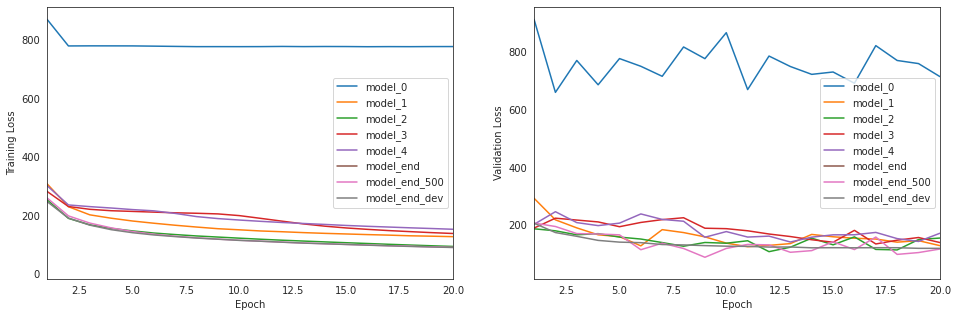

In [0]:

%matplotlib inline
sns.set_style(style='white')

# obtain the paths for the saved model history
all_pickles = sorted(glob("results/*.pickle"))
# extract the name of each model
model_names = [item[8:-7] for item in all_pickles]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

As seen from the plots, all the models exhibit similar behavior while training. Validation CTC losses of all the simple RNN models fluctuate. The last model implemented shows least validation CTC losses throughout the epochs as compared to other models.

# Step 11: Get predictions using the trained models and check the transcript text

The method get_predictions is used to decode the predictions of the model. As explained earlier, RNN models give 29 probability values as output for each of the character in the audio. 'get_predictions' method gets output by selecting the character with the highest probability. The decoding is done using TensorFlow's in-built ctc_decode method. 

In [0]:


def get_predictions(index, partition, input_to_softmax, model_path, desc_file):
    """ Print a model's decoded predictions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        input_to_softmax (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    # load the train and test data
    data_gen = AudioGenerator()
    data_gen.__init__(spectrogram=False)
    data_gen.load_train_data(desc_file=desc_file)
    data_gen.load_validation_data(desc_file=desc_file)
    
    # obtain the true transcription and the audio features 
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
        
    # obtain and decode the acoustic model's predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    print("output length: {}".format(output_length))
    test_text = (K.eval(K.ctc_decode(prediction, output_length,greedy=False,top_paths=2)[0][1])+1).flatten().tolist()
    #print ('test:'  + ''.join(int_sequence_to_text(test_text)))
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length,greedy=False,top_paths=2)[0][0])+1).flatten().tolist()
    
    # play the audio file, and display the true and predicted transcriptions
    print('-'*80)
    Audio(audio_path)
    print('True transcription:\n' + '\n' + transcr)
    print('-'*80)
    print('Predicted transcription:\n' + '\n' + ''.join(int_sequence_to_text(pred_ints)))
    print('-'*80)
    return "".join(int_sequence_to_text(pred_ints))

In [0]:
# Running get_predictions for final_model
valid_predictedText = get_predictions(index=0, 
                    partition='train',
                    input_to_softmax=final_model
                        (input_dim=13, # change to 13 if you would like to use MFCC features
                            filters=100,
                            kernel_size=11, 
                            conv_stride=2,
                            conv_border_mode='same',
                            units=100), 
                    model_path='./results/model_end_500.h5',desc_file="train_clean_corpus.json")

/content/drive/My Drive/Colab Notebooks/projFin/NLND-End2End-Speech-Recognition/sample_models.py:178: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(100, activation="relu", return_sequences=True, implementation=2, name="rnn", recurrent_dropout=0.0)`
  return_sequences=True, implementation=2, dropout_U=0.0,name='rnn'),merge_mode="concat")(bn_cnn)
/content/drive/My Drive/Colab Notebooks/projFin/NLND-End2End-Speech-Recognition/sample_models.py:183: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(100, activation="relu", return_sequences=True, implementation=2, name="rnn1", recurrent_dropout=0.0)`
  return_sequences=True, implementation=2,dropout_U=0.0,name='rnn1'),merge_mode="concat")(bn_rnn)
/content/drive/My Drive/Colab Notebooks/projFin/NLND-End2End-Speech-Recognition/sample_models.py:187: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(100, activation="relu", return_sequences=True, implementation=2, name="rnn2", recurrent_dropout=0.0)`
  return_s

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 100)         14400     
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 100)         400       
_________________________________________________________________
bidirectional_13 (Bidirectio (None, None, 200)         120600    
_________________________________________________________________
dropout_9 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
bidirectional_14 (Bidirectio (None, None, 200)         1806

 From above transcript text we can see that the predicted transcript text is closer to the original text in terms of pronunciations. But the spellings of the predicted text varies greatly. This is the drawback of using RNN-CTC model for the ASR. This can be overcome by using language models on the transcript text. We implemented two methods to correct the spelling mistakes of the predicted transcript text. The two methods are:
 - Using TextBlob in-built functionality
 - Using n-gram model

# Step 12: Use the in-built method of textblob to correct predicted transcript text

In [0]:

blob = TextBlob(valid_predictedText)
print("-"*80)
print("Spelling correction: \n \n{}".format(blob.correct()))
print("-"*80)

--------------------------------------------------------------------------------
Spelling corecctection: 
 
we the full won the o billet inn sont great could thesis
--------------------------------------------------------------------------------


# Step 13: Define spelling mistake corrector based on n-gram model

This method builds on top of textblob's correct() implemented earlier. The output from earlier method is passed to the method 'suggest' that returns bigram suggestions for the given word using corpus. 

In [0]:


def sentence_to_bigrams(sentence):
    """
    Add start '<s>' and stop '</s>' tags to the sentence and tokenize it into a list
    of lower-case words (sentence_tokens) and bigrams (sentence_bigrams)
    :param sentence: string
    :return: list, list
        sentence_tokens: ordered list of words found in the sentence
        sentence_bigrams: a list of ordered two-word tuples found in the sentence
    """
    sentence_tokens = ['<s>'] + sentence.lower().split() + ['</s>']
    sentence_bigrams = []
    for i in range(len(sentence_tokens)-1):
        sentence_bigrams.append((sentence_tokens[i], sentence_tokens[i+1]))
    return sentence_tokens, sentence_bigrams

def bigrams_from_sentences(sentences):
    """
    read a file of sentences, adding start '<s>' and stop '</s>' tags; Tokenize it into a list of lower case words
    and bigrams
    :param filename: string 
        filename: path to a text file consisting of lines of non-puncuated text; assume one sentence per line
    :return: list, list
        tokens: ordered list of words found in the file
        bigrams: a list of ordered two-word tuples found in the file
    """
    tokens = []
    bigrams = []
    for sentence in sentences:
        line_tokens, line_bigrams = sentence_to_bigrams(sentence)
        tokens = tokens + line_tokens
        bigrams = bigrams + line_bigrams
    return tokens, bigrams    
 
def find_bigram_count(sentences):
    bg_dict = defaultdict(dict)
    for sentence in sentences:
        split_sentence = sentence.split()
        for i in range(len(split_sentence)-1):
            first_word = split_sentence[i]
            second_word = split_sentence[i+1]
            if first_word in bg_dict.keys():
                if second_word in bg_dict[first_word].keys():
                    bg_dict[first_word][second_word]+=1
                else:
                    bg_dict[first_word][second_word] = 1
            else:
                bg_dict[first_word][second_word] = 1
    return bg_dict

def bigram_suggestions(first_word, input_dataset):
    bigram = find_bigram_count(input_dataset)
    tokens, _ = bigrams_from_sentences(input_dataset)
    token_counts = Counter(tokens)
    token_val = token_counts[first_word]
    suggestions = {}
    for b in bigram[first_word]:
        suggestions[b] = bigram[first_word][b]/float(token_val)
    return suggestions

def generate_corpus(desc_file):
    data_sentences = AudioGenerator()
    data_sentences.load_train_data(desc_file=desc_file)
    sentences = data_sentences.train_texts
    return sentences

def suggest(word,desc_file):
    """
    Returns bi-gram suggestions based on the 
    """
    return bigram_suggestions(word,generate_corpus(desc_file=desc_file))

# Step 14: Final results

### Used final_model to predict the transcript text
### Used n-gram model to correct the spelling mistakes of the predicted text

In [0]:
correct_text = []
# Append the first word assuming that is correct 
correct_text.append(blob.correct().split()[0])

# Assuming the prediction size same as the ground truth one
for word_indx in range(len(valid_predictedText.split())-1):
    # Checking if next_word is in suggested words
    next_word = blob.correct().split()[word_indx+1]
    dict_ = suggest(correct_text[-1],"train_clean_corpus.json")
    if next_word not in dict_:
        # Return to the function once the word is predicted
        def innerLoop():
            # Spelling might not be correct so it starts with the original length and reduces one by one
            for i in range(len(next_word)):
                # Find matching key using regular expressions 
                found = re.compile(next_word[0:len(next_word)-i])
                for key in dict_.keys():
                    if found.match(key):
                        print("N-Gram prediction of word {} is {}".format(next_word,key))
                        correct_text.append(key)
                        return 
                    elif len(dict_.keys()) == 1:
                        for key in dict_.keys():
                            print("N-Gram prediction of word {} is {}".format(next_word,key))
                            correct_text.append(key)
                            return
        innerLoop()
      
    else:
        print("Word prediction is correct for  {}".format(next_word))
        correct_text.append(next_word)
               
print("-"*80)
print("Language Model Prediction: \n\n"+" ".join(correct_text))
print("-"*80)

N-Gram prediction of word the is truthful
N-Gram prediction of word full is ones
N-Gram prediction of word won is was
Word prediction is correct for  the
N-Gram prediction of word o is outgrowth
N-Gram prediction of word billet is of
N-Gram prediction of word inn is indifference
N-Gram prediction of word sont is and
Word prediction is correct for  great
N-Gram prediction of word could is company
N-Gram prediction of word thesis is they
--------------------------------------------------------------------------------
Language Model Prediction: 

we truthful ones was the outgrowth of indifference and great company they
--------------------------------------------------------------------------------


In [0]:

test_predictedText = get_predictions(index=2, 
                partition='validation',
                input_to_softmax=final_model
                    (input_dim=13, # change to 13 if you would like to use MFCC features
                        filters=100,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='same',
                        units=100),
                model_path='./results/model_end_500.h5',desc_file='valid_corpus.json')

/content/drive/My Drive/Colab Notebooks/projFin/NLND-End2End-Speech-Recognition/sample_models.py:178: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(100, activation="relu", return_sequences=True, implementation=2, name="rnn", recurrent_dropout=0.0)`
  return_sequences=True, implementation=2, dropout_U=0.0,name='rnn'),merge_mode="concat")(bn_cnn)
/content/drive/My Drive/Colab Notebooks/projFin/NLND-End2End-Speech-Recognition/sample_models.py:183: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(100, activation="relu", return_sequences=True, implementation=2, name="rnn1", recurrent_dropout=0.0)`
  return_sequences=True, implementation=2,dropout_U=0.0,name='rnn1'),merge_mode="concat")(bn_rnn)
/content/drive/My Drive/Colab Notebooks/projFin/NLND-End2End-Speech-Recognition/sample_models.py:187: UserWarning: Update your `GRU` call to the Keras 2 API: `GRU(100, activation="relu", return_sequences=True, implementation=2, name="rnn2", recurrent_dropout=0.0)`
  return_s

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 13)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 100)         14400     
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 100)         400       
_________________________________________________________________
bidirectional_16 (Bidirectio (None, None, 200)         120600    
_________________________________________________________________
dropout_11 (Dropout)         (None, None, 200)         0         
_________________________________________________________________
bn_rnn (BatchNormalization)  (None, None, 200)         800       
_________________________________________________________________
bidirectional_17 (Bidirectio (None, None, 200)         1806

In [0]:
blob = TextBlob(test_predictedText)
print("-"*80)
print("Spelling corecctection: \n\n{}".format(blob.correct()))
print("-"*80)

--------------------------------------------------------------------------------
Spelling corecctection: 

i that de bit had west by in ty be in and his issued oo is and 
--------------------------------------------------------------------------------


In [0]:


correct_text = []
# Append the first word assuming that is correct 
#correct_text.append(test_predictedText.split()[0])
correct_text.append(blob.correct().split()[0])

# Assuming the prediction size same as the ground truth one
for word_indx in range(len(test_predictedText.split())-1):
    # Checking if next_word is in suggested words
    #next_word = test_predictedText.split()[word_indx+1]
    next_word = blob.correct().split()[word_indx+1]
    dict_ = suggest(correct_text[-1],"valid_corpus.json")
    if next_word not in dict_:
        # Return to the function once the word is predicted
        def innerLoop():
            # Spelling might not be correct so it start with the original length and reduces one by one
            for i in range(len(next_word)):
                # Find matching key using regular expressions 
                found = re.compile(next_word[0:len(next_word)-i])
                for key in dict_.keys():
                    if found.match(key):
                        print("N-Gram prediction of word {} is {}".format(next_word,key))
                        correct_text.append(key)
                        return 
                    elif len(dict_.keys()) == 1:
                        for key in dict_.keys():
                            print("N-Gram prediction of word {} is {}".format(next_word,key))
                            correct_text.append(key)
                            return
        innerLoop()
      
    else:
        print("Word prediction is correct for  {}".format(next_word))
        correct_text.append(next_word)
               
print("-"*80)
print("Language Model Prediction: \n\n"+" ".join(correct_text))
print("-"*80)

N-Gram prediction of word that is thank
N-Gram prediction of word had is him
N-Gram prediction of word west is we
N-Gram prediction of word by is been
Word prediction is correct for  in
N-Gram prediction of word ty is those
N-Gram prediction of word in is i
Word prediction is correct for  and
Word prediction is correct for  his
N-Gram prediction of word issued is ignorance
N-Gram prediction of word oo is and
Word prediction is correct for  is
N-Gram prediction of word and is annoyance
--------------------------------------------------------------------------------
Language Model Prediction: 

i thank him we been in those i and his ignorance and is annoyance
--------------------------------------------------------------------------------


#  Future Work:

As per our Professor's suggestions, we researched on Attention Model.
So far the models we have implmented are RNNs or LSTMs only. The main drawback of these models is when the encoder creates a bad summary, then the resulting translation will also be bad.
And also due to the vanishing exploding gradient problem, we cannot use RNNs for longer sentences and sequences

Attention Model is a solution to the limitation of the Encoder-Decoder model which we use in RNNs/LSTMs, where we encoding the input sequence to one fixed length vector from which to decode each output time step. 

Attention is proposed as a method that identifies which parts of the input sequence are relevant to each word in the output and using the relevant information to select the appropriate output - Align and Translate

# Conclusion:
- We implemented various RNN architectures to understand and explore various RNN architectures
- Using the basic architectures, we implemented a complex RNN architecture with CNN and bidirectional RNN
- In the basic models, Deeper RNN model that used multiple recurrent layers gave the best CTC loss
- Spectrogram features proved useful since the dataset was only 2136 training examples.
- Use of clean data like LibriSpeech, helped limit errors and feature modeling part so that we could focus more on implementing RNN architectures
- RNN architectures take a lot of time to run. RNN architectures may have vanishing gradients issue. We successfully avoided the vanishing gradients issue by using optimizers with clipnorm(). 
- We also used GRU for most of the models as GRU avoids vanishing gradients.
- As stated initially, use of RNN-CTC architectures does not help with spellings of the text predicted in case of ASR. We found that using n-gram models, we were able to get more correct spellings of the predicted text than just the use of RNN models.

# References:
[1] M. Sahidullah and G. Saha, “Design, analysis and experimental evaluation of block based transformation in MFCC computation for speaker recognition,” vol. 54, no. 4. pp.  

[2] “Spectrogram.” 2020, Accessed: May 03, 2020. [Online]. Available: https://en.wikipedia.org/w/index.php?title=Spectrogram&oldid=952207954  

[3] https://github.com/udacity/AIND-VUI-Capstone  

[4] https://github.com/oucler/NLND-End2End-Speech-Recognition/tree/5cdcc64cced82df2724f84f7a62fd32c0e301888

[5] “Mel-frequency cepstrum,” 2019. https://en.wikipedia.org/w/index.php?title=Mel-frequency_cepstrum&oldid=931814206 (accessed May 03, 2020).

[6] “Mel scale,” 2020. https://en.wikipedia.org/w/index.php?title=Mel_scale&oldid=950711154 (accessed May 04, 2020).

[7] T. Mayeesha, “Multi class Fish Classification on Images using Transfer Learning and Keras,” 2018. https://medium.com/learning-machine-learning/multi-class-fish-classification-from-images-with-transfer-learning-using-keras-335125637544 (accessed May 04, 2020).

[8] Bahdanau, Dzmitry, Kyunghyun Cho, and Yoshua Bengio. "Neural machine translation by jointly learning to align and translate." arXiv preprint arXiv:1409.0473 (2014).

[9] https://lagunita.stanford.edu/c4x/Engineering/CS-224N/asset/slp4.pdf

[10] http://web.stanford.edu/class/cs124/lec/languagemodeling2016.pdf

[11] https://www.youtube.com/watch?v=PJ_KCTsOCrs

[12] https://github.com/baidu-research/warp-ctc

[13] http://machinelearning.wustl.edu/mlpapers/paper_files/icml2006_GravesFGS06.pdf